 # Índice de Modelo Recursivo (RMI)

Es como un "índice de índices" que usa modelos matemáticos para predecir la ubicación de un dato. La magia está en su naturaleza recursiva: un modelo te da una ubicación aproximada, y luego otro modelo (o varios) te ayudan a afinar esa predicción, como un mapa que te lleva a un área, y luego un mapa más detallado para esa área específica

### Preparación de Datos

In [1]:
import numpy as np # operaciones de datos
import matplotlib.pyplot as plt # Para visualizaciones

crearemos un conjunto de datos de ejemplo ordenados (es indispensable que sea ordenado)

In [2]:
# Creamos un array de enteros ordenados para nuestro ejemplo
# Simulemos un conjunto de datos grande y ordenado
data_size = 1_000_000
data = np.sort(np.random.randint(0, data_size * 2, data_size))

print(f"Tamaño del conjunto de datos: {len(data)}")
print(f"Primeros 10 elementos: {data[:10]}")
print(f"Últimos 10 elementos: {data[-10:]}")

Tamaño del conjunto de datos: 1000000
Primeros 10 elementos: [ 0  4  7  9 12 13 16 18 22 23]
Últimos 10 elementos: [1999970 1999971 1999973 1999977 1999979 1999984 1999986 1999990 1999992
 1999995]


### Implementación de Regresión Lineal por Mínimos Cuadrados

Para la RMI necesitamos nuestra propia función para calcular los coeficientes de una regresión lineal. La regresión lineal simple busca la línea recta (y=mx+b) que mejor se ajusta a un conjunto de puntos, minimizando la suma de los cuadrados de las distancias verticales entre los puntos y la línea.

Las fórmulas para la pendiente (m) y el intercepto (b) son:

m= (N∑(xy)−∑x∑y​) / (N∑(x2)−(∑x)2)

b= (y−m∑x​) / N

Donde:

    N es el número de puntos.
    ∑x es la suma de todos los valores de x.
    ∑y es la suma de todos los valores de y.
    ∑(xy) es la suma de los productos de cada x por su y correspondiente.
    ∑(x2) es la suma de los cuadrados de cada x.

In [3]:
def train_linear_model(X, y):
    """
    Entrena un modelo de regresión lineal simple (y = mx + b)
    utilizando el método de mínimos cuadrados.

    Args:
        X (np.array): Array de valores de entrada (característica).
        y (np.array): Array de valores de salida (objetivo).

    Returns:
        tuple: Una tupla (m, b) donde m es la pendiente y b es el intercepto.
               Retorna (None, None) si no hay suficientes datos para entrenar.
    """
    n = len(X)
    if n < 2: # Necesitamos al menos dos puntos para una línea
        return None, None

    sum_x = np.sum(X)
    sum_y = np.sum(y)
    sum_xy = np.sum(X * y)
    sum_x_squared = np.sum(X**2)

    # Evitar división por cero si todos los X son iguales
    denominator = n * sum_x_squared - sum_x**2
    if denominator == 0:
        # Si todos los X son iguales, la línea es vertical o constante.
        # Aquí, si X es constante, la predicción de y debería ser la media de y.
        # Para RMI, esto es un caso degenerado, pero podemos asumir pendiente 0.
        m = 0.0
        b = np.mean(y)
    else:
        m = (n * sum_xy - sum_x * sum_y) / denominator
        b = (sum_y - m * sum_x) / n

    return m, b

def predict_linear_model(value, m, b):
    """
    Realiza una predicción utilizando un modelo lineal (y = mx + b).

    Args:
        value (float): El valor de entrada para la predicción.
        m (float): La pendiente del modelo.
        b (float): El intercepto del modelo.

    Returns:
        float: La predicción y.
    """
    return m * value + b

#### Nivel 0: El Modelo Maestro (Predicción Global)

Nuestro RMI de dos niveles comienza con el modelo maestro o modelo de Nivel 0. Su misión es simple: dado un valor de búsqueda, predecir el rango aproximado o el segmento en nuestro conjunto de datos donde podría estar.

Piensen en él como el "mapa general" que te dirige a una región amplia. Para nuestro Nivel 0, usaremos la función train_linear_model que acabamos de crear. Entrenaremos este modelo para que aprenda la relación entre un valor de dato y su posición (índice) en el array.

Coeficiente (pendiente) del modelo de Nivel 0: 0.027844
Intercepto del modelo de Nivel 0: 472170.165804


/tmp/ipykernel_1471555/3042074420.py:24: RuntimeWarning: overflow encountered in scalar multiply
  denominator = n * sum_x_squared - sum_x**2
/tmp/ipykernel_1471555/3042074420.py:32: RuntimeWarning: overflow encountered in scalar multiply
  m = (n * sum_xy - sum_x * sum_y) / denominator


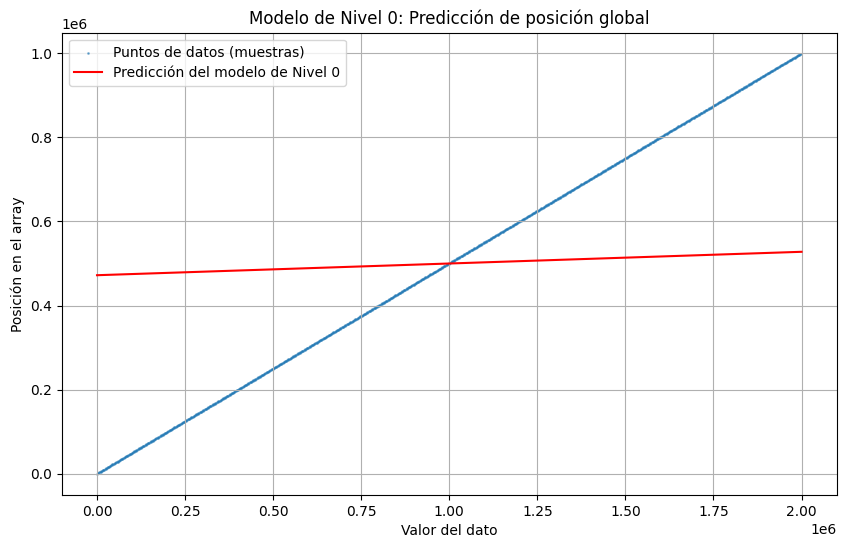

In [4]:
# Preparamos los datos para el entrenamiento del modelo de Nivel 0
# X (entrada) será el valor del dato
# Y (salida) será el índice (posición) del dato en el array
X_level0 = data
y_level0 = np.arange(len(data)) # Los índices del 0 al tamaño del data - 1

# Entrenamos nuestro modelo de regresión lineal
m_level0, b_level0 = train_linear_model(X_level0, y_level0)

print(f"Coeficiente (pendiente) del modelo de Nivel 0: {m_level0:.6f}")
print(f"Intercepto del modelo de Nivel 0: {b_level0:.6f}")

# Visualicemos cómo se ve esta línea de predicción
plt.figure(figsize=(10, 6))
# Muestreamos los datos para no dibujar un millón de puntos, solo algunos para visualizar
plt.scatter(X_level0[::1000], y_level0[::1000], s=1, alpha=0.5, label='Puntos de datos (muestras)')
plt.plot(X_level0, predict_linear_model(X_level0, m_level0, b_level0), color='red', label='Predicción del modelo de Nivel 0')
plt.title('Modelo de Nivel 0: Predicción de posición global')
plt.xlabel('Valor del dato')
plt.ylabel('Posición en el array')
plt.legend()
plt.grid(True)
plt.show()

### Nivel 1: Los Modelos Especializados (Afinando la Predicción)

El modelo de Nivel 0 nos da una predicción aproximada. Ahora, el Nivel 1 refinará esa estimación. Consiste en múltiples modelos más pequeños y especializados, cada uno enfocado en una porción específica de nuestro conjunto de datos.

Imagina que el modelo maestro te envió a la sección "300-400" de un libro. Ahora, dentro del Nivel 1, tienes un modelo hiper-especializado para esa sección que te dirá la página exacta.

#### Dividiendo los Datos en Segmentos y Entrenando

Necesitamos decidir cuántos modelos de Nivel 1 tendremos. Este número, num_level1_models, es crucial y afectará tanto la precisión como el tamaño de nuestro índice. Las predicciones del Nivel 0 nos ayudarán a asignar cada dato a un modelo de Nivel 1.

In [5]:
# Definimos el número de modelos en el Nivel 1
# Este es un hiperparámetro que equilibra precisión y tamaño del índice.
num_level1_models = 1000 # Por ejemplo, 1000 modelos en el Nivel 1

# Pre-calculamos las predicciones del Nivel 0 para todo el dataset
# Esto nos ayuda a asignar cada dato a un segmento de Nivel 1
predicted_indices_level0_for_data = predict_linear_model(X_level0, m_level0, b_level0)

# Asignamos cada dato a un modelo de Nivel 1 basado en la predicción del Nivel 0.
# Escalamos la predicción al rango [0, num_level1_models - 1]
# Usamos int() para obtener el índice del modelo.
model_assignments = (predicted_indices_level0_for_data / len(data) * num_level1_models).astype(int)

# Aseguramos que las asignaciones estén dentro de los límites válidos [0, num_level1_models - 1]
model_assignments = np.clip(model_assignments, 0, num_level1_models - 1)

# Creamos una lista para almacenar nuestros modelos de Nivel 1 (pares de pendiente e intercepto)
level1_models = [(None, None)] * num_level1_models

# Para cada modelo de Nivel 1, también queremos saber qué rango de índices originales "cubre"
# Esto es útil para la fase de refinamiento final.
model_actual_start_indices = [0] * num_level1_models
model_actual_end_indices = [0] * num_level1_models

print(f"Entrenando {num_level1_models} modelos para el Nivel 1...")

# Itera sobre cada segmento posible de Nivel 1
for i in range(num_level1_models):
    # Seleccionamos los datos que han sido "asignados" a este modelo de Nivel 1
    mask = (model_assignments == i)
    
    # Verificamos si hay datos en este segmento para entrenar el modelo
    if np.sum(mask) > 0:
        segment_X = X_level0[mask]
        segment_y = y_level0[mask] # Son los índices reales de estos datos

        # Entrenamos nuestro modelo lineal para este segmento
        m_level1, b_level1 = train_linear_model(segment_X, segment_y)
        level1_models[i] = (m_level1, b_level1)

        # Registramos los índices reales que este segmento contiene
        model_actual_start_indices[i] = np.min(segment_y)
        model_actual_end_indices[i] = np.max(segment_y)
    else:
        # Si un segmento no tiene datos, su modelo permanecerá como (None, None).
        # Esto requerirá un manejo especial durante la búsqueda.
        # En una implementación más robusta, se podría recurrir a un modelo vecino o un fallback.
        model_actual_start_indices[i] = -1 # Marcar como no válido
        model_actual_end_indices[i] = -1 # Marcar como no válido


print("Entrenamiento de modelos de Nivel 1 completado.")

Entrenando 1000 modelos para el Nivel 1...


/tmp/ipykernel_1471555/3042074420.py:24: RuntimeWarning: overflow encountered in scalar multiply
  denominator = n * sum_x_squared - sum_x**2
/tmp/ipykernel_1471555/3042074420.py:32: RuntimeWarning: overflow encountered in scalar multiply
  m = (n * sum_xy - sum_x * sum_y) / denominator


Entrenamiento de modelos de Nivel 1 completado.


### Construyendo la Función de Búsqueda del RMI

Ahora que nuestros modelos están entrenados, podemos crear la función que realizará la búsqueda. Esta función tomará un valor y lo buscará en nuestro array utilizando el RMI.

La búsqueda en un RMI de dos niveles funciona así:

    Paso 1 (Nivel 0): Usamos el modelo maestro para obtener una predicción inicial de la posición del valor en el array.
    Paso 2 (Selección del Modelo de Nivel 1): Basado en esa predicción inicial, calculamos qué modelo específico del Nivel 1 debemos usar.
    Paso 3 (Nivel 1): Usamos el modelo de Nivel 1 seleccionado para obtener una predicción más precisa.
    Paso 4 (Refinamiento Final - Búsqueda Local): Como las predicciones de los modelos pueden no ser exactas y los índices deben ser enteros, realizamos una búsqueda lineal local (o binaria si la ventana es grande) alrededor de la posición predicha. Esto nos permite encontrar el valor exacto si existe, o su punto de inserción.

In [6]:
def rmi_search(value, data, m_level0, b_level0, level1_models, num_level1_models, 
               model_actual_start_indices, model_actual_end_indices):
    """
    Realiza una búsqueda utilizando el RMI de dos niveles.

    Args:
        value (int): El valor a buscar.
        data (np.array): El array ordenado de datos.
        m_level0 (float): Pendiente del modelo de Nivel 0.
        b_level0 (float): Intercepto del modelo de Nivel 0.
        level1_models (list): Lista de tuplas (m, b) para los modelos de Nivel 1.
        num_level1_models (int): Número total de modelos en el Nivel 1.
        model_actual_start_indices (list): Índices de inicio reales de los segmentos de Nivel 1.
        model_actual_end_indices (list): Índices de fin reales de los segmentos de Nivel 1.

    Returns:
        int: El índice donde se encuentra el valor, o el índice donde debería insertarse.
    """
    data_len = len(data)

    # Paso 1: Predicción con el modelo de Nivel 0
    predicted_index_level0 = predict_linear_model(value, m_level0, b_level0)

    # Paso 2: Seleccionar el modelo de Nivel 1
    # Convertimos la predicción del Nivel 0 en un índice para el modelo de Nivel 1
    model_idx_level1 = int((predicted_index_level0 / data_len) * num_level1_models)

    # Aseguramos que el índice del modelo esté dentro de los límites válidos
    model_idx_level1 = np.clip(model_idx_level1, 0, num_level1_models - 1)

    m_level1, b_level1 = level1_models[model_idx_level1]

    # Manejo si el modelo de Nivel 1 no fue entrenado (segmento vacío)
    if m_level1 is None:
        # Esto es un escenario a manejar. Una opción es buscar binariamente en un rango más amplio,
        # o recurrir a un modelo vecino. Para esta demo, haremos una búsqueda binaria global
        # si el modelo específico no existe.
        print(f"Advertencia: El modelo de Nivel 1 para el índice {model_idx_level1} no fue entrenado. Realizando búsqueda binaria global.")
        # np.searchsorted es una búsqueda binaria muy eficiente
        idx = np.searchsorted(data, value)
        return idx
    
    # Paso 3: Predicción con el modelo de Nivel 1
    predicted_index_level1 = predict_linear_model(value, m_level1, b_level1)

    # Paso 4: Refinamiento Final - Búsqueda local alrededor de la predicción
    # Convertimos la predicción a un entero.
    approx_index = int(predicted_index_level1)

    # Determinamos el rango de búsqueda local.
    # Usaremos los límites reales del segmento de datos que este modelo de Nivel 1 cubre,
    # más un margen de seguridad para errores de predicción.
    
    # Primero, obtenemos los límites reales del segmento que el modelo de Nivel 1 "espera" manejar
    actual_segment_start = model_actual_start_indices[model_idx_level1]
    actual_segment_end = model_actual_end_indices[model_idx_level1]

    # Definimos una ventana de búsqueda alrededor de la predicción
    # Un tamaño de ventana de, por ejemplo, 200 elementos es un buen punto de partida.
    # Esto ayuda a compensar errores de predicción.
    search_window_buffer = 100 
    
    # Calculamos el inicio y fin de la ventana de búsqueda, combinando la predicción y los límites del segmento
    # y asegurando que no salgan de los límites del array global.
    
    # El inicio de la búsqueda es el máximo entre 0, la predicción menos el buffer,
    # y el inicio real del segmento del modelo de Nivel 1.
    start_search = max(0, approx_index - search_window_buffer, actual_segment_start)
    
    # El fin de la búsqueda es el mínimo entre data_len, la predicción más el buffer,
    # y el fin real del segmento del modelo de Nivel 1 + 1 (para incluir el último elemento).
    end_search = min(data_len, approx_index + search_window_buffer + 1, actual_segment_end + 1)
    
    # Asegurarse de que start_search no sea mayor que end_search
    if start_search > end_search:
        start_search = max(0, end_search - 1) # Asegurar una ventana de al menos 1 elemento si es posible

    # Si la ventana es muy pequeña o inválida después de los ajustes
    if start_search >= data_len: # Si el inicio ya está fuera del array
        return data_len
    if end_search <= start_search: # Si la ventana es inválida o vacía
        end_search = start_search + 1 # Aseguramos al menos un punto de control

    # Realizamos una búsqueda binaria dentro de esta ventana local
    # Esto es más eficiente que una búsqueda lineal si la ventana es considerable.
    segment_data = data[start_search:end_search]
    idx_in_segment = np.searchsorted(segment_data, value)

    # El índice final es el inicio de la ventana más el índice dentro del segmento
    final_index = start_search + idx_in_segment
    
    # Verificamos si el valor está realmente en la posición encontrada
    # np.searchsorted devuelve el índice donde el elemento debería ser insertado para mantener el orden.
    # Esto significa que si el elemento existe, estará en `final_index` o `final_index - 1`.
    if final_index < data_len and data[final_index] == value:
        return final_index
    elif final_index > 0 and final_index <= data_len and data[final_index - 1] == value:
        return final_index - 1
    else:
        # El valor no se encontró, devolvemos el índice donde debería estar
        return final_index

### PRUEBA

In [7]:
def rmi_search(value, data, m_level0, b_level0, level1_models, num_level1_models, 
               model_actual_start_indices, model_actual_end_indices):
    """
    Realiza una búsqueda utilizando el RMI de dos niveles.

    Args:
        value (int): El valor a buscar.
        data (np.array): El array ordenado de datos.
        m_level0 (float): Pendiente del modelo de Nivel 0.
        b_level0 (float): Intercepto del modelo de Nivel 0.
        level1_models (list): Lista de tuplas (m, b) para los modelos de Nivel 1.
        num_level1_models (int): Número total de modelos en el Nivel 1.
        model_actual_start_indices (list): Índices de inicio reales de los segmentos de Nivel 1.
        model_actual_end_indices (list): Índices de fin reales de los segmentos de Nivel 1.

    Returns:
        int: El índice donde se encuentra el valor, o el índice donde debería insertarse.
    """
    data_len = len(data)

    # Paso 1: Predicción con el modelo de Nivel 0
    predicted_index_level0 = predict_linear_model(value, m_level0, b_level0)

    # Paso 2: Seleccionar el modelo de Nivel 1
    # Convertimos la predicción del Nivel 0 en un índice para el modelo de Nivel 1
    model_idx_level1 = int((predicted_index_level0 / data_len) * num_level1_models)

    # Aseguramos que el índice del modelo esté dentro de los límites válidos
    model_idx_level1 = np.clip(model_idx_level1, 0, num_level1_models - 1)

    m_level1, b_level1 = level1_models[model_idx_level1]

    # Manejo si el modelo de Nivel 1 no fue entrenado (segmento vacío)
    if m_level1 is None:
        # Esto es un escenario a manejar. Una opción es buscar binariamente en un rango más amplio,
        # o recurrir a un modelo vecino. Para esta demo, haremos una búsqueda binaria global
        # si el modelo específico no existe.
        print(f"Advertencia: El modelo de Nivel 1 para el índice {model_idx_level1} no fue entrenado. Realizando búsqueda binaria global.")
        # np.searchsorted es una búsqueda binaria muy eficiente
        idx = np.searchsorted(data, value)
        return idx
    
    # Paso 3: Predicción con el modelo de Nivel 1
    predicted_index_level1 = predict_linear_model(value, m_level1, b_level1)

    # Paso 4: Refinamiento Final - Búsqueda local alrededor de la predicción
    # Convertimos la predicción a un entero.
    approx_index = int(predicted_index_level1)

    # Determinamos el rango de búsqueda local.
    # Usaremos los límites reales del segmento de datos que este modelo de Nivel 1 cubre,
    # más un margen de seguridad para errores de predicción.
    
    # Primero, obtenemos los límites reales del segmento que el modelo de Nivel 1 "espera" manejar
    actual_segment_start = model_actual_start_indices[model_idx_level1]
    actual_segment_end = model_actual_end_indices[model_idx_level1]

    # Definimos una ventana de búsqueda alrededor de la predicción
    # Un tamaño de ventana de, por ejemplo, 200 elementos es un buen punto de partida.
    # Esto ayuda a compensar errores de predicción.
    search_window_buffer = 100 
    
    # Calculamos el inicio y fin de la ventana de búsqueda, combinando la predicción y los límites del segmento
    # y asegurando que no salgan de los límites del array global.
    
    # El inicio de la búsqueda es el máximo entre 0, la predicción menos el buffer,
    # y el inicio real del segmento del modelo de Nivel 1.
    start_search = max(0, approx_index - search_window_buffer, actual_segment_start)
    
    # El fin de la búsqueda es el mínimo entre data_len, la predicción más el buffer,
    # y el fin real del segmento del modelo de Nivel 1 + 1 (para incluir el último elemento).
    end_search = min(data_len, approx_index + search_window_buffer + 1, actual_segment_end + 1)
    
    # Asegurarse de que start_search no sea mayor que end_search
    if start_search > end_search:
        start_search = max(0, end_search - 1) # Asegurar una ventana de al menos 1 elemento si es posible

    # Si la ventana es muy pequeña o inválida después de los ajustes
    if start_search >= data_len: # Si el inicio ya está fuera del array
        return data_len
    if end_search <= start_search: # Si la ventana es inválida o vacía
        end_search = start_search + 1 # Aseguramos al menos un punto de control

    # Realizamos una búsqueda binaria dentro de esta ventana local
    # Esto es más eficiente que una búsqueda lineal si la ventana es considerable.
    segment_data = data[start_search:end_search]
    idx_in_segment = np.searchsorted(segment_data, value)

    # El índice final es el inicio de la ventana más el índice dentro del segmento
    final_index = start_search + idx_in_segment
    
    # Verificamos si el valor está realmente en la posición encontrada
    # np.searchsorted devuelve el índice donde el elemento debería ser insertado para mantener el orden.
    # Esto significa que si el elemento existe, estará en `final_index` o `final_index - 1`.
    if final_index < data_len and data[final_index] == value:
        return final_index
    elif final_index > 0 and final_index <= data_len and data[final_index - 1] == value:
        return final_index - 1
    else:
        # El valor no se encontró, devolvemos el índice donde debería estar
        return final_index

Análisis y Reflexiones sobre la Implementación Manual

Hemos construido nuestro RMI sin bibliotecas especializadas para los modelos. Esto nos ha permitido ver de cerca cómo:

    La regresión lineal por mínimos cuadrados calcula los parámetros (m y b) que definen la línea de mejor ajuste.
    El Nivel 0 da una predicción global, y el Nivel 1 refina esa predicción dentro de un segmento más pequeño.
    La búsqueda local es indispensable para corregir las pequeñas desviaciones de las predicciones del modelo y encontrar el índice exacto o el punto de inserción. Su eficiencia es crítica, y usar np.searchsorted en la ventana local es una optimización clave.

La Importancia de los Hiperparámetros

    num_level1_models: Este es el número de "segmentos" o "sub-modelos" en el segundo nivel. Si es muy bajo, los modelos de Nivel 1 tendrán que cubrir rangos muy amplios, lo que podría hacer sus predicciones menos precisas y requerir ventanas de búsqueda local más grandes. Si es muy alto, el RMI ocupará más memoria (más modelos que almacenar) y el entrenamiento será más lento.
    search_window_buffer: Este buffer define el tamaño de la ventana de búsqueda local alrededor de la predicción final. Un buffer más grande aumenta la probabilidad de encontrar el elemento correcto incluso con errores de predicción mayores, pero a expensas de más trabajo en la búsqueda local. Un buffer pequeño es más rápido, pero podría fallar si la predicción es muy inexacta.

¿Qué sucede con los segmentos vacíos?

Hemos visto que si un segmento en el Nivel 1 no tiene datos asignados, su modelo queda como (None, None). En una implementación real y robusta, esto podría manejarse de varias maneras:

    Fusión de segmentos: Unir el segmento vacío con un vecino.
    Modelo predeterminado: Usar un modelo lineal genérico o del vecino más cercano.
    Recurrir a búsqueda binaria global: Como lo hicimos en nuestro ejemplo, pero esto puede ser menos eficiente.

Ventajas de esta Implementación Manual

    Comprensión Profunda: Al escribir el código de regresión y búsqueda, entendemos exactamente qué cálculos se realizan y por qué.
    Control Total: Tenemos control granular sobre cómo se entrena cada modelo y cómo se realiza la búsqueda.
    Sin Dependencias Pesadas: Mantenemos nuestro código ligero, dependiendo solo de numpy para la eficiencia de los arrays.

Conclusión

Hemos logrado construir un Índice de Modelo Recursivo (RMI) básico de dos niveles implementando cada parte de manera manual, incluyendo la regresión lineal por mínimos cuadrados. Esto nos da una visión clara de cómo funcionan estos índices modernos, utilizando el poder de los modelos predictivos para acelerar las búsquedas en grandes conjuntos de datos ordenados.

Este es un paso fundamental para comprender el balance entre la precisión del modelo, el espacio de almacenamiento del índice y la velocidad de búsqueda. En el siguiente paso, podríamos explorar cómo se compara este RMI con estructuras de datos tradicionales como el B-Tree, realizando un análisis comparativo de rendimiento y uso de memoria.